In [1]:
import numpy as np
import ot
import trimesh
import open3d as o3d
import utils
from utils import GM
from tqdm import trange

#plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pathlib import Path

In [2]:
models_path = Path.cwd()/'data/models'

In [6]:
sqd = 500 #parameter for mesh simplification

#LOAD ANIMALS dataset
animals = ['camel', 'cat', 'elephant', 'face', 'flamingo', 'head', 'horse', 'lion']
meshes_animals_500 = []
names = []
for animal in animals:
    counter = 1
    pathlist = (models_path/f"{animal}-poses").rglob('*.obj')
    for path_to_obj in pathlist:
        filepath = str(path_to_obj)
        pcd = o3d.io.read_triangle_mesh(filepath)
        mesh = trimesh.Trimesh(vertices=pcd.vertices,faces = pcd.triangles)
        
        #simplifiy mesh
        mesh = mesh.simplify_quadric_decimation(sqd)
        
        #append mesh to list
        meshes_animals_500.append(mesh)
        names.append(animal + str(counter).zfill(2))
        counter += 1

In [3]:
sqd = 50 #parameter for mesh simplification

#LOAD ANIMALS dataset
animals = ['camel', 'cat', 'elephant', 'face', 'flamingo', 'head', 'horse', 'lion']
meshes_animals_50 = []
names = []
for animal in animals:
    counter = 1
    pathlist = (models_path/f"{animal}-poses").rglob('*.obj')
    for path_to_obj in pathlist:
        filepath = str(path_to_obj)
        pcd = o3d.io.read_triangle_mesh(filepath)
        mesh = trimesh.Trimesh(vertices=pcd.vertices,faces = pcd.triangles)
        
        #simplifiy mesh
        mesh = mesh.simplify_quadric_decimation(sqd)
        
        #append mesh to list
        meshes_animals_50.append(mesh)
        names.append(animal + str(counter).zfill(2))
        counter += 1

In [ ]:
#LOAD few ANIMALS dataset
animals_few = ['camel', 'horse', 'lion']
meshes_animals_few = []
names_few = []
for animal in animals_few:
    counter = 1
    pathlist = (models_path/f"{animal}-poses").rglob('*.obj')
    for path_to_obj in pathlist:
        filepath = str(path_to_obj)
        pcd = o3d.io.read_triangle_mesh(filepath)
        mesh = trimesh.Trimesh(vertices=pcd.vertices,faces = pcd.triangles)
        
        #simplifiy mesh
        mesh = mesh.simplify_quadric_decimation(sqd)
        
        #append mesh to list
        meshes_animals_few.append(mesh)
        names_few.append(animal + str(counter).zfill(2))
        counter += 1

In [ ]:
# meshes_animals_all = meshes_animals
meshes_animals = meshes_animals_few

In [ ]:
# meshes_animals = meshes_animals_all[::3]

In [ ]:
%%time 
data_size = len(meshes_animals)

pairwise_distances = np.zeros((data_size, data_size))

for mesh1_i in range(data_size):
    
    mesh = meshes_animals[mesh1_i]
    X = GM(X=mesh.vertices,
               Tris=mesh.faces,
               mode="surface",
               gauge_mode="djikstra",
               normalize_gauge=True,
               squared=False)
    
    for mesh2_i in range(mesh1_i+1, data_size):
        
        mesh = meshes_animals[mesh2_i]
        Y = GM(X=mesh.vertices,
               Tris=mesh.faces,
               mode="surface",
               gauge_mode="djikstra",
               normalize_gauge=True,
               squared=False)
        
        P,log = ot.gromov.gromov_wasserstein(X.g,Y.g,X.xi,Y.xi,log=True)

        pairwise_distances[mesh1_i, mesh2_i] = log["gw_dist"]
        
        print(f"Current pair: {mesh1_i} and {mesh2_i}")

pairwise_distances += pairwise_distances.T

In [ ]:
!pip install opencv-python

In [4]:
from utils_lgw import lgw_procedure

In [ ]:
lgw_procedure??

In [24]:
animals

['camel', 'cat', 'elephant', 'face', 'flamingo', 'head', 'horse', 'lion']

In [29]:
names
ref_is = [0, 0+11, 0+11+10, 0+11+10+11, 0+11+10+11+10, 0+11+10+11+10+11, 0+11+10+11+10+11+10, 0+11+10+11+10+11+10+10]

In [30]:
len(ref_is)

8

In [32]:
%%time

def GM_short(mesh):
    return GM(X=mesh.vertices, Tris=mesh.faces, mode="surface", gauge_mode="djikstra", normalize_gauge=True, squared=False)

aggregated_distances_lgw = []
for i in ref_is:
    print(f"Counting wrt reference {i}")
    mesh_ref = meshes_animals_500[i]
    obj_ref = GM_short(mesh_ref)
    
    M_ref, height_ref = obj_ref.g, obj_ref.xi
    
    Ms = [GM_short(mesh).g for mesh in meshes_animals_500]
    heights = [GM_short(mesh).xi for mesh in meshes_animals_500]
    
    pairwise_distances_lgw, _ = lgw_procedure(M_ref,height_ref,None,Ms,heights,max_iter=1000, mode="graph")
    aggregated_distances_lgw.append(pairwise_distances_lgw)

CPU times: user 15min 35s, sys: 46.1 s, total: 16min 21s
Wall time: 12min 54s


In [35]:
arr = np.stack(aggregated_distances_lgw)
np.save('aggregated_distances_lgw_sqd500', arr)
arr.shape

(8, 83, 83)

In [37]:
np.save('image_names', names)

In [ ]:
np.array(aggregated_distances_lgw).shape

In [ ]:
Y = GM(X=mesh.vertices,
       Tris=mesh.faces,
       mode="surface",
       gauge_mode="djikstra",
       normalize_gauge=True,
       squared=False)

P,log = ot.gromov.gromov_wasserstein(X.g,Y.g,X.xi,Y.xi,log=True)

In [9]:
pairwise_distances_lgw

(array([[0.        , 0.05510141, 0.05593423, ..., 0.10117345, 0.09541332,
         0.07928659],
        [0.05510141, 0.        , 0.04713521, ..., 0.12739634, 0.10878277,
         0.0918447 ],
        [0.05593423, 0.04713521, 0.        , ..., 0.12239928, 0.11161122,
         0.09420519],
        ...,
        [0.10117345, 0.12739634, 0.12239928, ..., 0.        , 0.11177608,
         0.10667027],
        [0.09541332, 0.10878277, 0.11161122, ..., 0.11177608, 0.        ,
         0.07107732],
        [0.07928659, 0.0918447 , 0.09420519, ..., 0.10667027, 0.07107732,
         0.        ]]),
 36.03319501876831)

In [10]:
np.save('pairwise_distances_lgw_sqd500', pairwise_distances_lgw[0])
pairwise_distances_lgw[0]

array([[0.        , 0.05510141, 0.05593423, ..., 0.10117345, 0.09541332,
        0.07928659],
       [0.05510141, 0.        , 0.04713521, ..., 0.12739634, 0.10878277,
        0.0918447 ],
       [0.05593423, 0.04713521, 0.        , ..., 0.12239928, 0.11161122,
        0.09420519],
       ...,
       [0.10117345, 0.12739634, 0.12239928, ..., 0.        , 0.11177608,
        0.10667027],
       [0.09541332, 0.10878277, 0.11161122, ..., 0.11177608, 0.        ,
        0.07107732],
       [0.07928659, 0.0918447 , 0.09420519, ..., 0.10667027, 0.07107732,
        0.        ]])

In [ ]:
pairwise_distances_old == pairwise_distances

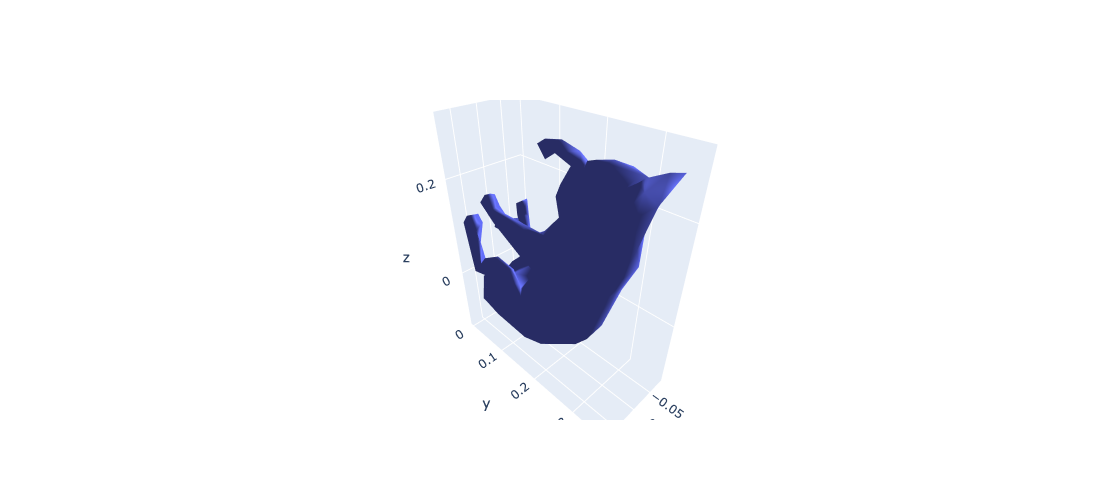

In [21]:
width = 500
height = 500
ambient = 0.4

i = 11
mesh = meshes_animals_500[i]

fig = make_subplots(rows=1, cols=1,
               specs=[[{'type': 'scene'}] * 1],shared_xaxes=True)
fig.add_trace(
    go.Mesh3d(
    x=mesh.vertices[:,0],
    y=mesh.vertices[:,1],
    z=mesh.vertices[:,2],
    # i, j and k give the vertices of triangles
    i=mesh.faces[:,0],
    j=mesh.faces[:,1],
    k=mesh.faces[:,2],
    showscale=False,
    lighting=dict(ambient=ambient)
),
    row = 1, col = 1
)
fig.update_layout(showlegend=False,width=width,height=height)
fig.update_scenes(aspectmode='data')
fig = go.FigureWidget(fig)
fig.show()

In [ ]:
%%time

#choose gm-spaces
i = 0
j = 1

mesh = meshes_animals[i]
X = GM(X=mesh.vertices,Tris=mesh.faces,mode="surface",gauge_mode="djikstra",squared=False)

mesh = meshes_animals[j]
Y = GM(X=mesh.vertices,Tris=mesh.faces,mode="surface",gauge_mode="djikstra",squared=False)


#compute GW Plan
P,log = ot.gromov.gromov_wasserstein(X.g,Y.g,X.xi,Y.xi,log=True)
print("GW Transport costs: {0}".format(log["gw_dist"]))

In [ ]:
#colour-code X
cX = np.linalg.norm(X.X - np.min(X.X),axis=1)
#colour-code Y according to transport P
cY = (P.T / np.sum(P,axis=1)).dot(cX)

#plot
fig = make_subplots(rows=1, cols=2,
               specs=[[{'type': 'scene'}] * 2],shared_xaxes=True)
#plot X
fig.add_trace(
    go.Mesh3d(
    x=X.X[:,0],
    y=X.X[:,1],
    z=X.X[:,2],
    # Intensity of each vertex, which will be interpolated and color-coded
    intensity=cX,
    # i, j and k give the vertices of triangles
    i=X.Tris[:,0],
    j=X.Tris[:,1],
    k=X.Tris[:,2],
    showscale=False,
    lighting=dict(ambient=ambient)
),
    row = 1, col = 1
)

#plot Y
fig.add_trace(
    go.Mesh3d(
    x=Y.X[:,0],
    y=Y.X[:,1],
    z=Y.X[:,2],
    # Intensity of each vertex, which will be interpolated and color-coded
    intensity=cY,
    # i, j and k give the vertices of triangles
    i=Y.Tris[:,0],
    j=Y.Tris[:,1],
    k=Y.Tris[:,2],
    showscale=False,
    lighting=dict(ambient=ambient)
),
    row = 1, col = 2
)

fig.update_scenes(aspectmode='data')
fig.update_layout(showlegend=False,width=width,height=height)

fig = go.FigureWidget(fig)
fig.show()